In [2]:
defaultW <- getOption("warn")
options(warn = -1)
library(sp)
library(sf)
library(rgdal)
library(rgeos)
library(maptools)
library(stringr)
library(spdep)
library(spatstat)
library(splancs)
#gpclibPermit()
library(raster)
library(data.table)
require(spatialreg)
options(warn = defaultW)

# 0 - Dataset description
The data presented in this  project comes from my personal Garmin data. Basically every bike ride has been resampled every 5 minutes, aggregating all the informations (heart rate, speed, etc.) with their own mean.

First I needed to change the Coordinate Reference System from longlat to UTM in order to have the same coordinate of the istat dataset.

In [3]:
data_garmin = read.csv("garmin_data/dati.csv")
data_garmin$long = as.numeric(data_garmin$long)
data_garmin$lat = as.numeric(data_garmin$lat)
# Change reference system
xy <- data_garmin
coordinates(xy) <- c("long", "lat")
proj4string(xy) <- CRS("+proj=longlat +zone=32 +datum=WGS84 +units=m +no_defs +ellps=WGS84 +towgs84=0,0,0")
new_coord = spTransform(xy, CRS("+proj=utm +zone=32 +datum=WGS84 +units=m +no_defs +ellps=WGS84 +towgs84=0,0,0"))
data_garmin$long = as.numeric(new_coord$long)
data_garmin$lat = as.numeric(new_coord$lat)
data_garmin_shp <- SpatialPointsDataFrame(data_garmin[,c('long','lat')], data_garmin,
                proj4string = CRS("+proj=utm +zone=32 +datum=WGS84 +units=m +no_defs +ellps=WGS84 +towgs84=0,0,0"))
head(data_garmin)

,X,lat,long,distance,enhanced_altitude,altitude,enhanced_speed,speed,heart_rate,cadence,act_id,ts
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,52,4851734,680216.2,0.92151,125.8,125.8,26.2296,26.2296,107,68,1,2016-01-10 10:15:00
2,53,4850591,679171.0,2.59930,117.4,117.4,25.1766,25.1766,122,67,1,2016-01-10 10:20:00
3,55,4850151,678484.1,3.89113,115.0,115.0,21.8628,21.8628,119,71,1,2016-01-10 10:30:00
4,56,4850978,677918.1,5.20613,112.6,112.6,24.0372,24.0372,119,73,1,2016-01-10 10:35:00
5,57,4851331,675997.9,7.34763,108.4,108.4,26.4672,26.4672,135,80,1,2016-01-10 10:40:00
6,58,4851229,673759.0,9.58845,108.4,108.4,29.2356,29.2356,140,87,1,2016-01-10 10:45:00


Show the heart rate histogram, just to see "how much I push" (not that much actually).

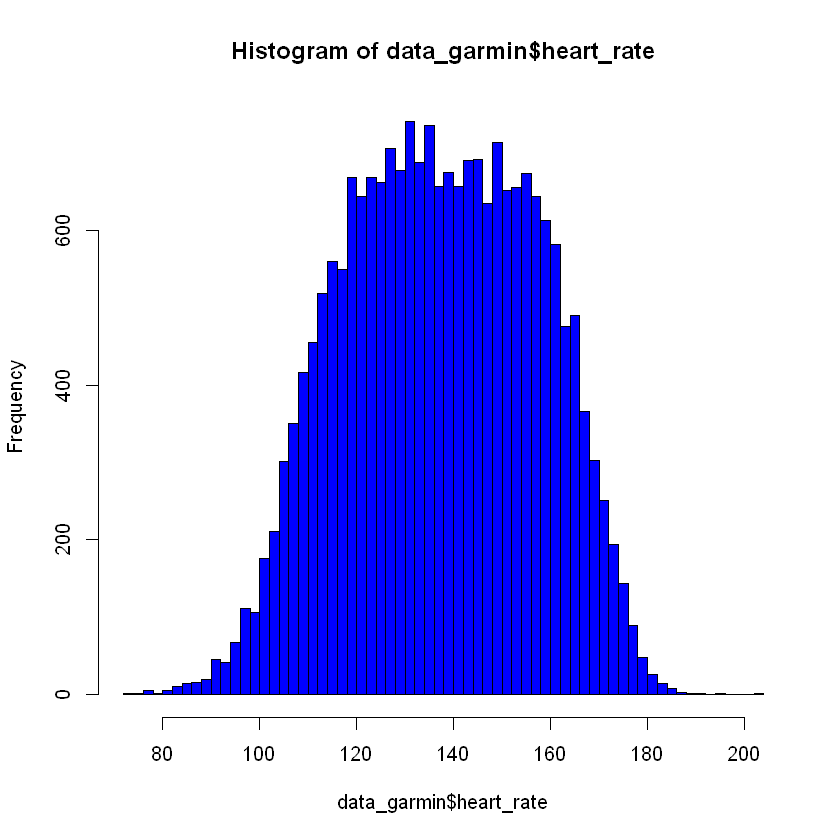

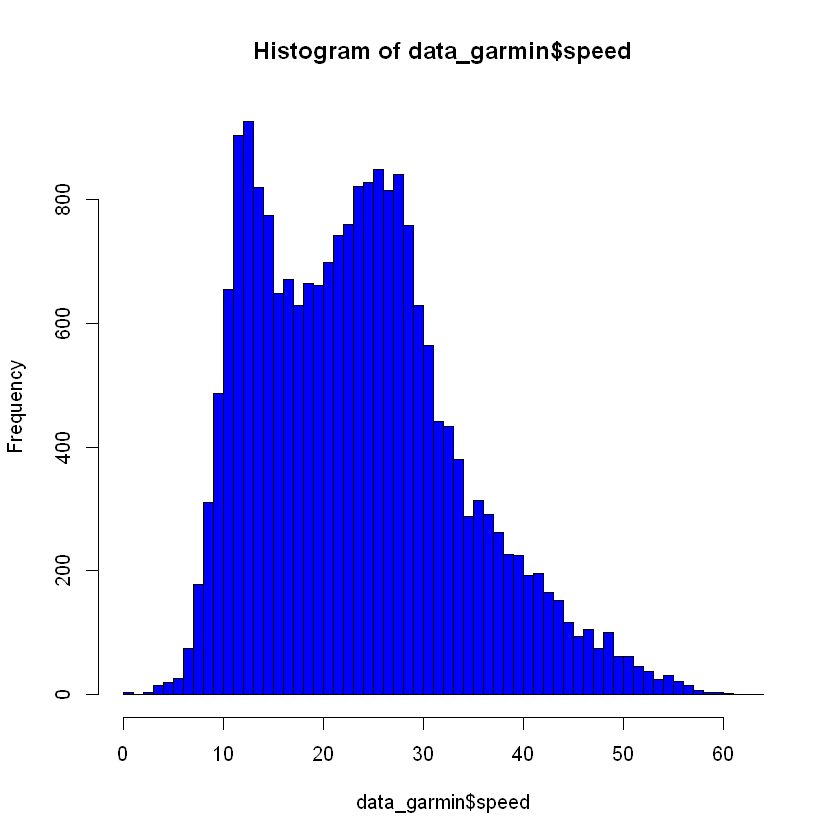

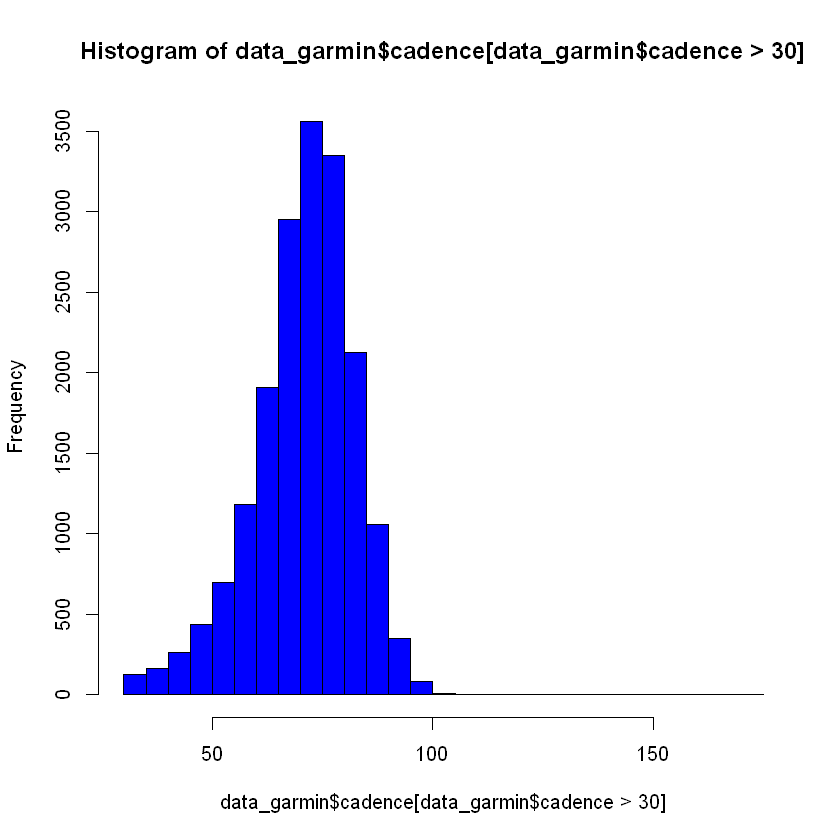

In [4]:
options(jupyter.plot_scale=1)
hist(data_garmin$heart_rate, col='blue', breaks=50)
hist(data_garmin$speed, col='blue', breaks=50)
hist(data_garmin$cadence[data_garmin$cadence>30], col='blue', breaks=50)

Load the municipality data from shapefile.

In [5]:
ita_com = readOGR("external_shp/Com01012018_g/Com01012018_g_WGS84.shp")
ita_com$COD_PROV = as.numeric(ita_com$COD_PROV)
ita_com$COD_REG = as.numeric(ita_com$COD_REG)
ita_com$PRO_COM = as.numeric(ita_com$PRO_COM)
head(as.data.frame(ita_com))

OGR data source with driver: ESRI Shapefile 
Source: "C:\Users\peppu\Documents\MyPythonProject\geospatial_project\external_shp\Com01012018_g\Com01012018_g_WGS84.shp", layer: "Com01012018_g_WGS84"
with 7960 features
It has 14 fields
Integer64 fields read as strings:  COD_RIP COD_REG COD_PROV COD_CM COD_PCM PRO_COM CC_P_CM 


,SHAPE_LENG,COD_RIP,COD_REG,COD_PROV,COD_CM,COD_PCM,PRO_COM,PRO_COM_T,COMUNE,COMUNE_A,CC_P_CM,SHAPE_LE_1,SHAPE_AREA,SHAPE_LEN
,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
0,16192.777,1,1,1,201,201,1004,001004,Albiano d'Ivrea,NA,0,16192.66,11033556,16192.66
1,18083.594,1,1,1,201,201,1005,001005,Alice Superiore,NA,0,18083.46,7508489,18083.46
2,16077.366,1,1,1,201,201,1006,001006,Almese,NA,0,16077.25,17717104,16077.25
3,8909.466,1,1,1,201,201,1007,001007,Alpette,NA,0,8909.40,5321039,8909.40
4,15511.692,1,1,1,201,201,1008,001008,Alpignano,NA,0,15511.57,11982594,15511.57
5,11559.538,1,1,1,201,201,1009,001009,Andezeno,NA,0,11559.45,7495051,11559.45


# 1 - Heart Rate Analysis
In the graph below I plot the ride I made in Tuscany as black points. The red points are the areas where I push over 170 beat per minute of heart rate.

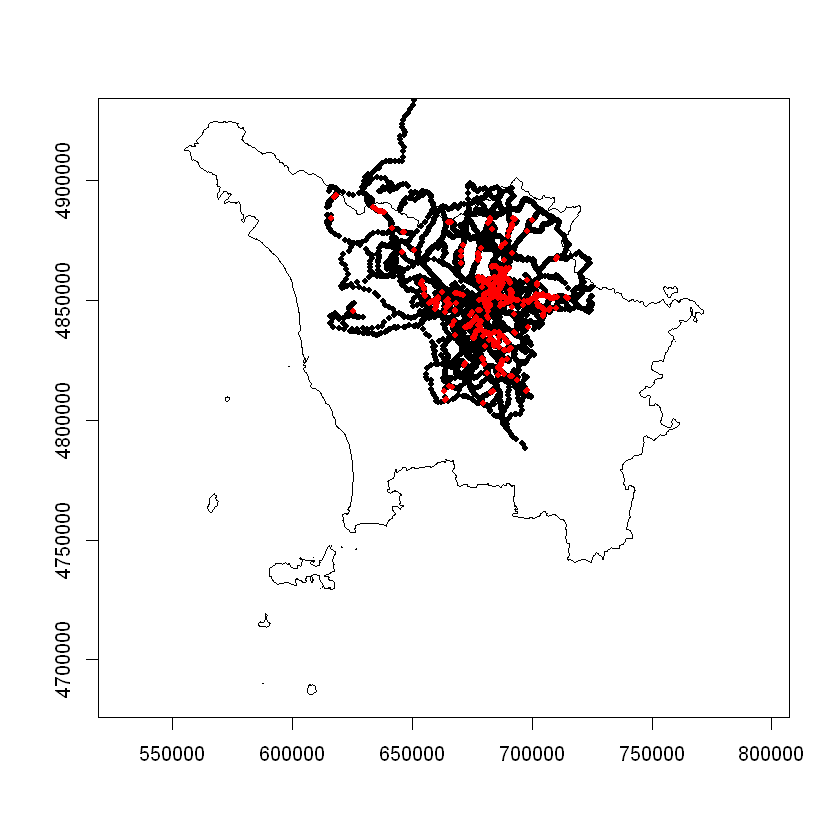

In [6]:
options(jupyter.plot_scale=1)
regione_toscana = subset(ita_com, COD_REG==9) # Select tuscany
regione_toscana = ita_com[(ita_com$COD_REG==9) & (ita_com$COD_PROV!=53),] # Delete districts where I did not ride ever
tosc_boundary = unionSpatialPolygons(regione_toscana,IDs = rep(1,nrow(regione_toscana))) # Merge the polygons
plot(tosc_boundary,axes=T) # Plot della toscana
points(data_garmin[,c('long','lat')],pch=20) # points(data_garmin_shp,pch=20, add=TRUE) -  plot dei punti
points(data_garmin[data_garmin$heart_rate>170,c('long','lat')], pch=20,col = 'red') # plot dei punti sopra 170 hrm

In the plot below I focused only on Firenze municipality. This municipality will be excluded from the analysis since it cotains the beginning and the end of each ride, causing a "polarized" view of the dataset.

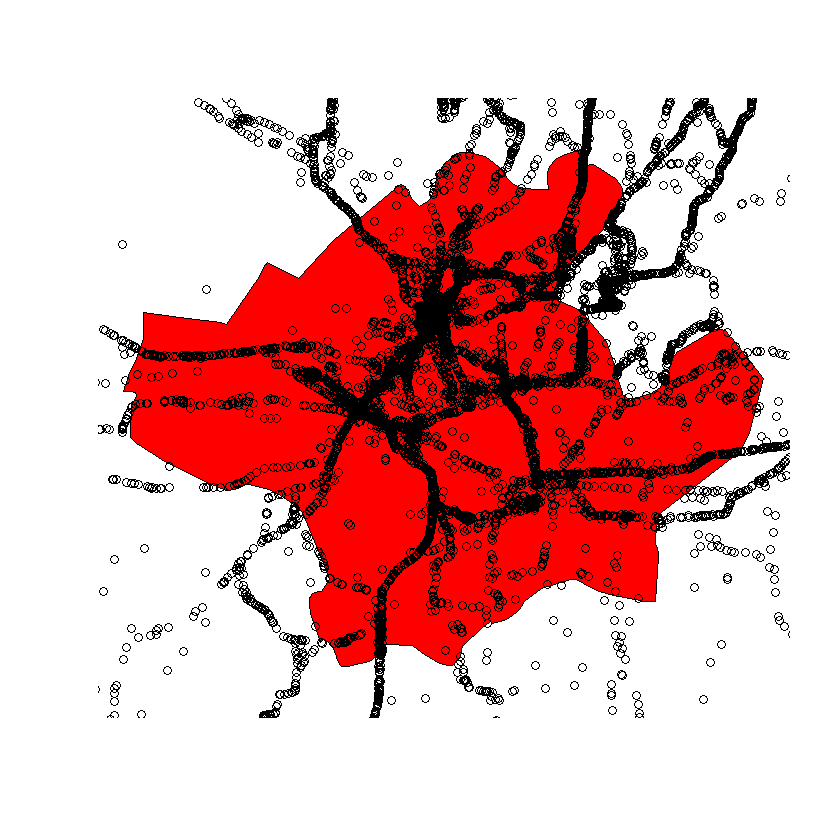

In [7]:
plot(subset(ita_com, COMUNE=='Firenze'),c='red')
points(data_garmin_shp)

## 1.2 Where do I ride the most? And where do I push the most?
In the below plots I tried to show where I ride the most and where I push and where I don't. <br>
Florence municipality has been excluded because of the reason explained above.

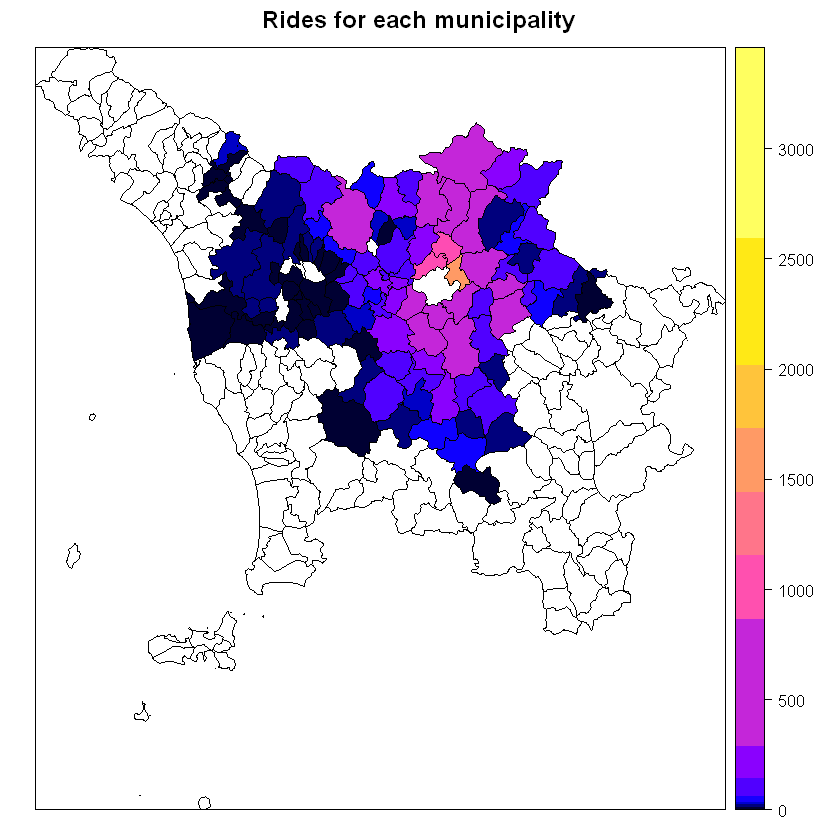

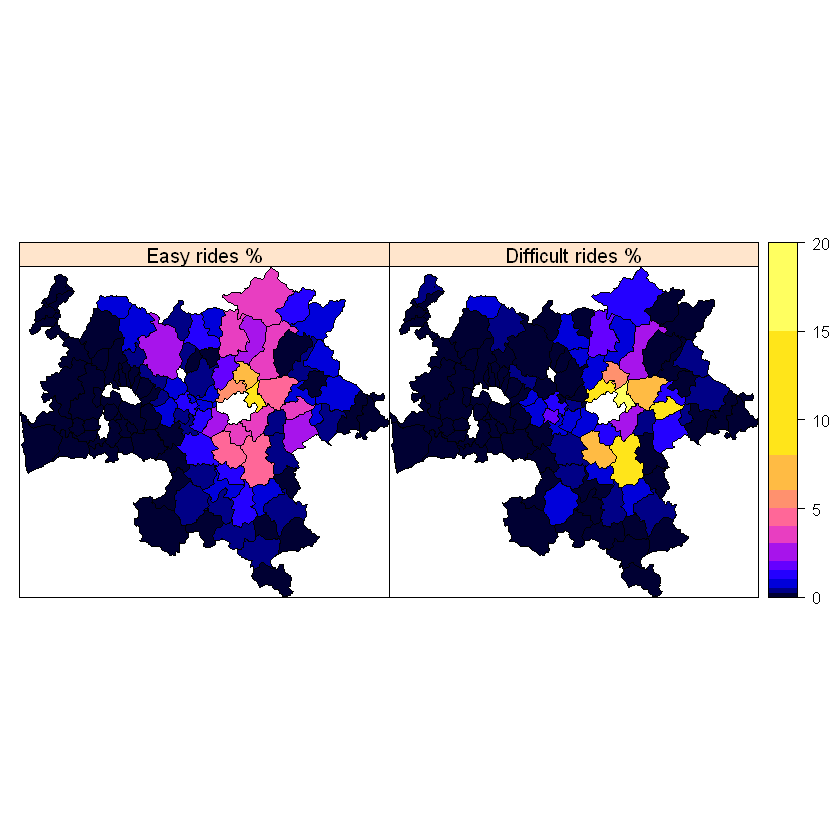

In [8]:
options(jupyter.plot_scale=1)

# Get the counters for the difficulty (easy, difficult) of on each municipality
heart_rate_data = over(data_garmin_shp, ita_com)
heart_rate_data = cbind(data_garmin_shp$heart_rate>170,heart_rate_data) # Put True if over 170, false otherwise
heart_rate_data = heart_rate_data[heart_rate_data$PRO_COM!=48017,] # Firenze is excluded because it is a sort of outlier
names(heart_rate_data)[1] <- "grado_diff"

# Aggregate by "easy" and "difficult"
agg_over = table(heart_rate_data$PRO_COM,heart_rate_data$grado_diff)
agg_over = as.data.frame(cbind(as.numeric(rownames(agg_over)),agg_over))
names(agg_over) <- c("PRO_COM","facile","difficile")

agg_over$perc_facile <- agg_over$facile/sum(agg_over$facile) * 100
agg_over$perc_difficile <- agg_over$difficile/sum(agg_over$difficile) * 100

# Get all points to plot entire tuscany region
unified_points <- merge(regione_toscana,agg_over,by="PRO_COM")
unified_points$all_rides <- unified_points$difficile + unified_points$facile

# Get points only where I rode
agg_filter = subset(agg_over,(facile>0) | (difficile>0))
filtered_points <- merge(regione_toscana,agg_filter,by="PRO_COM", all=FALSE)
filtered_points$all_rides <- filtered_points$difficile + filtered_points$facile

spplot(unified_points,"all_rides",
       at=c(0,12,2*12,3*12,5*12,12*12,24*12,72*12,96*12,120*12,144*12,168*12,216*12,144*2*12),
       main = "Rides for each municipality")

spplot(filtered_points,c("perc_facile","perc_difficile"),
       at=c(0,0.2,0.5,1,1.5,2,3,4,5,6,8,15,20),
      names.attr=c("Easy rides %","Difficult rides %"))

Here below I wanted to create the same plot but using a kernel methodolody.

In [9]:
# Merge the boundary - NOTE: I tried to add Florence to avoid buondary problems but without success
tuscany_ridden = filtered_points # Use the districts where I rode at least once
tuscany_ridden = merge(tuscany_ridden,subset(regione_toscana,PRO_COM==48017),by="PRO_COM", all=TRUE)
tosc_no_fir_boundary = unionSpatialPolygons(tuscany_ridden,IDs = rep(1,nrow(tuscany_ridden))) # Merge the polygons

# Extract easy rides
facili = subset(data_garmin, heart_rate<170) # Easy rides
easy_ppp <- ppp(facili$long,facili$lat, window = as.owin(tosc_no_fir_boundary)) # Transform into Point Process Pattern
summary(easy_ppp) # From here, average intensity con be explored

# Extract difficult rides
difficili = subset(data_garmin, heart_rate>170) # Difficult rides
difficult_ppp <- ppp(difficili$long,difficili$lat, window = as.owin(tosc_no_fir_boundary))
summary(difficult_ppp) # From here, average intensity con be explored

sum(duplicated(easy_ppp)) # Check For duplicates
sum(duplicated(difficult_ppp)) # Check For duplicates

Warning message:
"6243 points were rejected as lying outside the specified window"


Planar point pattern:  13990 points
Average intensity 1.748451e-06 points per square unit

Coordinates are given to 1 decimal place
i.e. rounded to the nearest multiple of 0.1 units

Window: polygonal boundary
6 separate polygons (5 holes)
                 vertices         area relative.area
polygon 1            3027  8.19742e+09      1.02e+00
polygon 2 (hole)      105 -2.93595e+07     -3.67e-03
polygon 3 (hole)      160 -5.21865e+07     -6.52e-03
polygon 4 (hole)      304 -1.02593e+08     -1.28e-02
polygon 5 (hole)       46 -1.19003e+07     -1.49e-03
polygon 6 (hole)       15 -9.17437e+03     -1.15e-06
enclosing rectangle: [601860.3, 736218] x [4781245, 4901296] units
                     (134400 x 120100 units)
Window area = 8001370000 square units
Fraction of frame area: 0.496

*** 6243 illegal points stored in attr(,"rejects") ***

Warning message:
"48 points were rejected as lying outside the specified window"


Planar point pattern:  734 points
Average intensity 9.173432e-08 points per square unit

Coordinates are given to 1 decimal place
i.e. rounded to the nearest multiple of 0.1 units

Window: polygonal boundary
6 separate polygons (5 holes)
                 vertices         area relative.area
polygon 1            3027  8.19742e+09      1.02e+00
polygon 2 (hole)      105 -2.93595e+07     -3.67e-03
polygon 3 (hole)      160 -5.21865e+07     -6.52e-03
polygon 4 (hole)      304 -1.02593e+08     -1.28e-02
polygon 5 (hole)       46 -1.19003e+07     -1.49e-03
polygon 6 (hole)       15 -9.17437e+03     -1.15e-06
enclosing rectangle: [601860.3, 736218] x [4781245, 4901296] units
                     (134400 x 120100 units)
Window area = 8001370000 square units
Fraction of frame area: 0.496

*** 48 illegal points stored in attr(,"rejects") ***

[1] 0

[1] 0

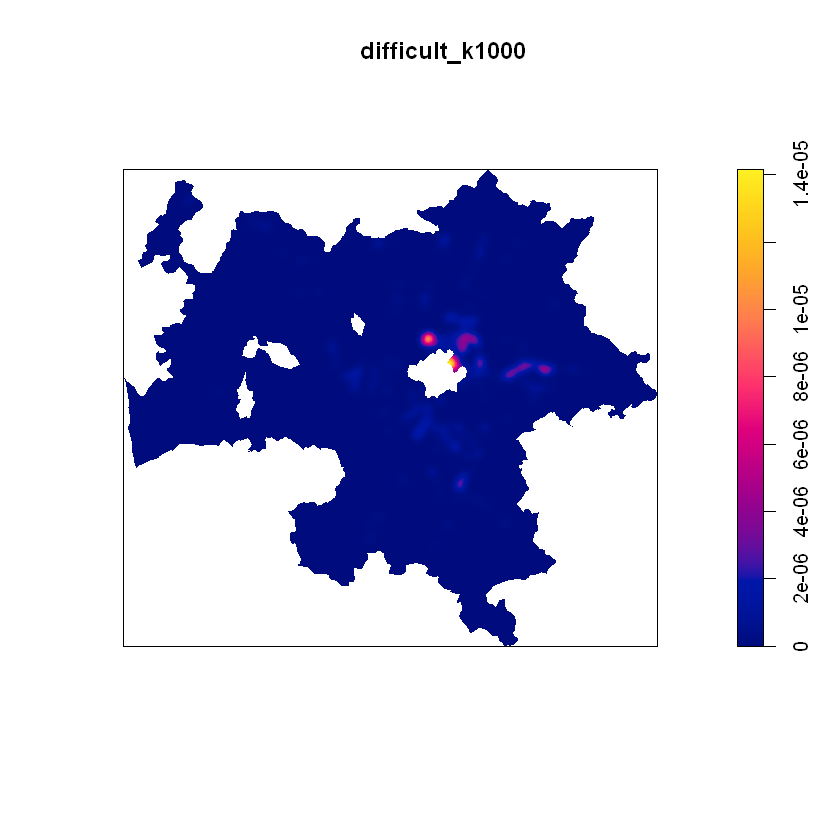

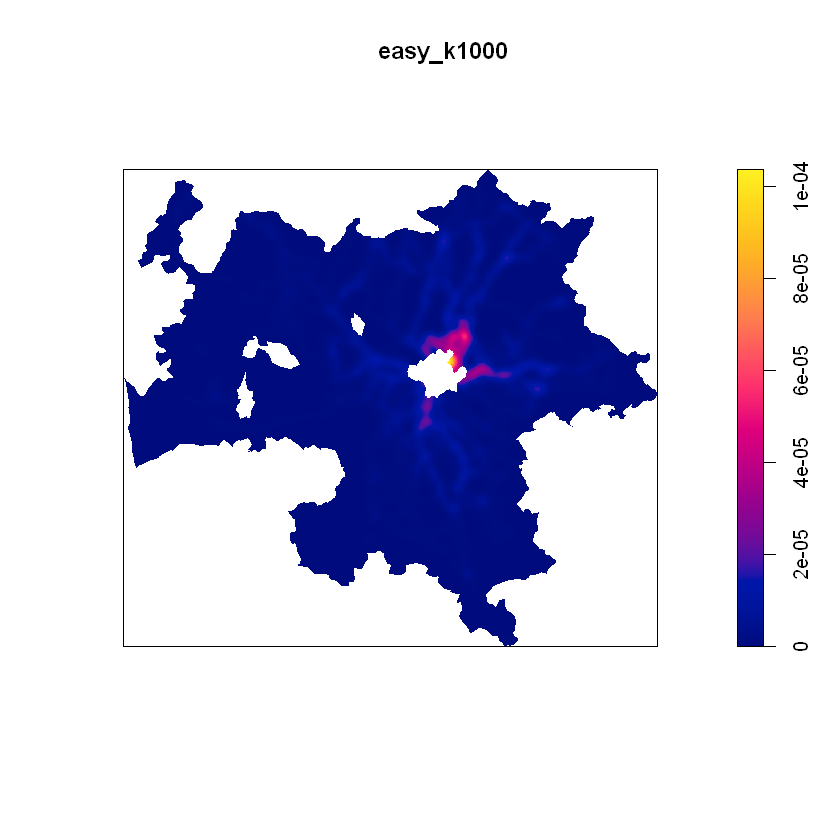

In [10]:
options(jupyter.plot_scale=1)

# Let's first define the grid for the plot
grid_def <- as.mask(as.owin(tosc_no_fir_boundary), dimyx = 1000)
difficult_k1000 <- density(difficult_ppp, sigma = 1000, xy=grid_def)
plot(difficult_k1000)
easy_k1000 <- density(easy_ppp, sigma = 1000, xy=grid_def) 
plot(easy_k1000)

Now I would like to see, in percentage, where there are more difficult rides with respect to easy rides.

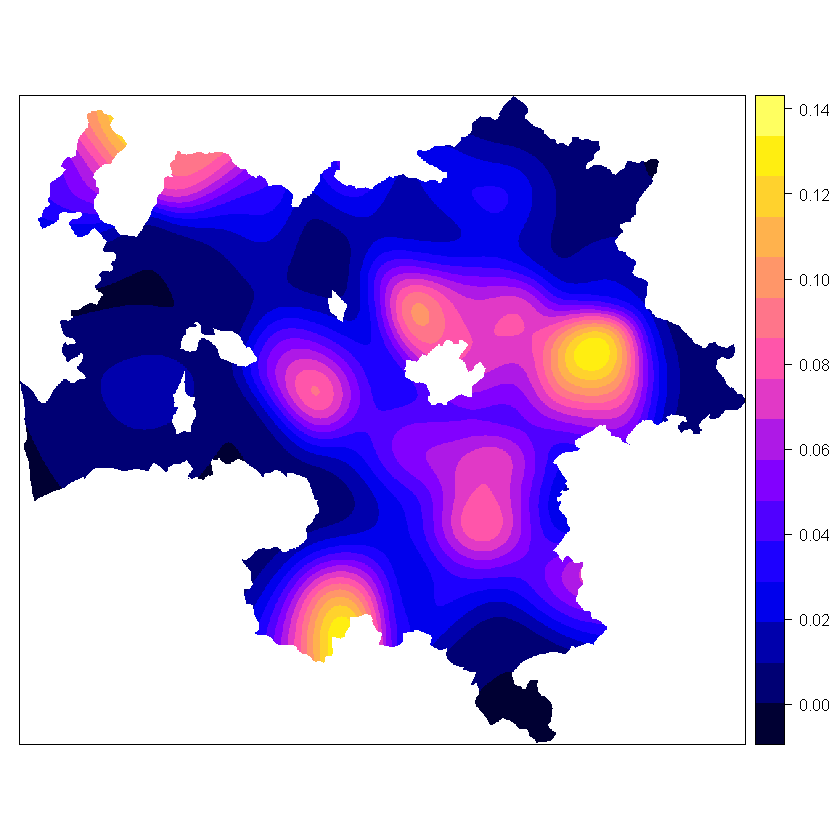

In [32]:
# Comparison Easy and difficult rides
grid_def <- as.mask(as.owin(tosc_no_fir_boundary), dimyx = 1000)

# Densities
dens.easy = density(easy_ppp, sigma = 5000, xy = grid_def)
df0 <- as(dens.easy, "SpatialGridDataFrame")
dens.difficult = density(difficult_ppp, sigma = 5000, xy = grid_def)
df0 = cbind(df0,as(dens.difficult, "SpatialGridDataFrame"))

names(df0) <- c("density.easy","density.difficult")

# Ratio of intensities
df0$kratio = df0$density.difficult/df0$density.easy
df0$kratio_inv = df0$density.easy/df0$density.difficult

spplot(df0, "kratio") #at=c(0,0.2,0.5,1,1.5,2,3,4,5,6,8,15,20)

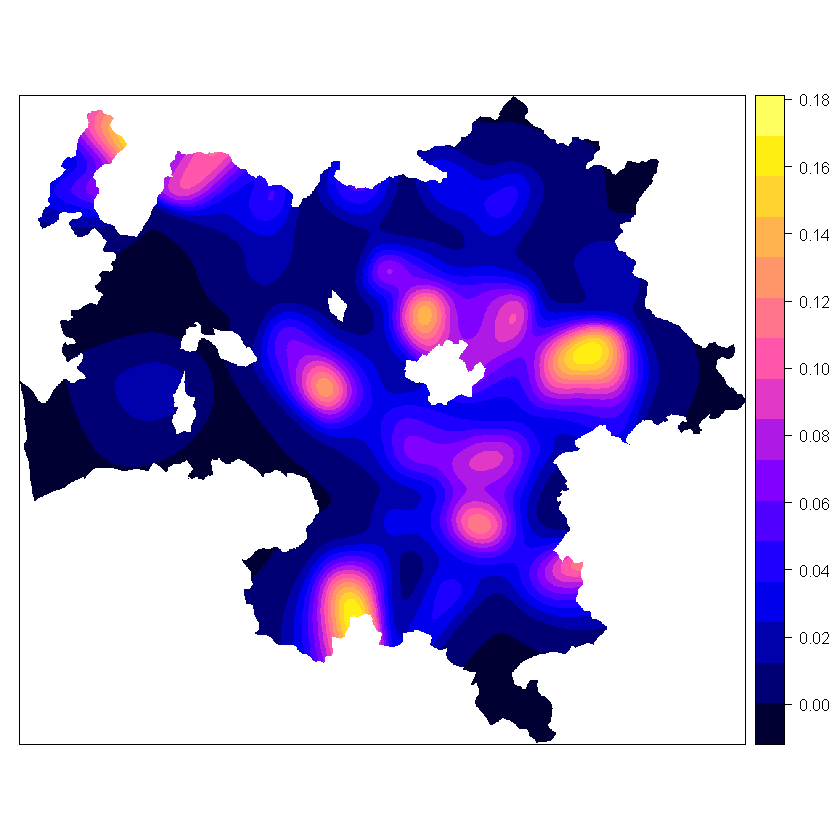

In [31]:
# Comparison Easy and difficult rides
grid_def <- as.mask(as.owin(tosc_no_fir_boundary), dimyx = 1000)

# Densities
dens.easy = density(easy_ppp, sigma = 3500, xy = grid_def)
df0 <- as(dens.easy, "SpatialGridDataFrame")
dens.difficult = density(difficult_ppp, sigma = 3500, xy = grid_def)
df0 = cbind(df0,as(dens.difficult, "SpatialGridDataFrame"))

names(df0) <- c("density.easy","density.difficult")

# Ratio of intensities
df0$kratio = df0$density.difficult/df0$density.easy
df0$kratio_inv = df0$density.easy/df0$density.difficult

spplot(df0, "kratio") #at=c(0,0.2,0.5,1,1.5,2,3,4,5,6,8,15,20)

# Backup

In [ ]:
conta[conta$PRO_COM==51023,]

In [ ]:
xy <- data_garmin
coordinates(xy) <- c("long", "lat")
proj4string(xy) <- CRS("+proj=longlat +zone=32 +datum=WGS84 +units=m +no_defs +ellps=WGS84 +towgs84=0,0,0")
new_coord = spTransform(xy, CRS("+proj=utm +zone=32 +datum=WGS84 +units=m +no_defs +ellps=WGS84 +towgs84=0,0,0"))

In [ ]:
plot(subset(ita_com, COMUNE=='Firenze'),c='red')
points(data_garmin_shp, add=TRUE)


In [ ]:
a$long

In [ ]:
as.data.frame(a)

In [ ]:
as.data.frame(subset(ita_com, COMUNE=='Firenze'))

In [ ]:
FI_PO_com = readOGR("C:/Users/peppu/Google Drive/Peppus/Università/Master/Lessons/Block2/GeoSpatialNetwork/GeoSpatial/R/shapes/FI_PO.shp")
as.data.frame(FI_PO_com)

In [ ]:
write.csv(as.data.frame(conta),'trash/aaaa.csv')

In [ ]:
unique(ita_com$PRO_COM!=48017)

In [ ]:
# Numero di casi per ogni comune (non si capisce, mettilo in fondo)
over_170 = over(data_garmin_shp, ita_com)
over_170 = cbind(data_garmin_shp$heart_rate>170,over_170)
over_170 = over_170[over_170$PRO_COM!=48017,] # Firenze is excluded because it is a sort of outlier
names(over_170)[1] <- "over_170"

# numero di casi e controlli per comune
barplot(table(over_170$COMUNE),main='Numero di "over_170" per comune')

In [ ]:
plot(altimetria)

In [ ]:
terrain

In [ ]:
a = readGDAL("external_shp/altitude100m.tif")
summary(a)
# summary(altimetria)
image(a, axes = T,col=terrain.colors(10))
plot(altimetria,col=terrain.colors(10))

In [ ]:
altimetria = readGDAL("external_shp/altitude100m.tif")
altimetria = spTransform(altimetria, CRS("+proj=utm +zone=32 +datum=WGS84 +k=0.9996 +x_0=1500000 +y_0=0 +ellps=intl"))
summary(altimetria)

In [104]:
summary.ppp(facili_ppp,checkdup=FALSE)

Planar point pattern:  13990 points
Average intensity 1.748451e-06 points per square unit
Window: polygonal boundary
6 separate polygons (5 holes)
                 vertices         area relative.area
polygon 1            3027  8.19742e+09      1.02e+00
polygon 2 (hole)      105 -2.93595e+07     -3.67e-03
polygon 3 (hole)      160 -5.21865e+07     -6.52e-03
polygon 4 (hole)      304 -1.02593e+08     -1.28e-02
polygon 5 (hole)       46 -1.19003e+07     -1.49e-03
polygon 6 (hole)       15 -9.17437e+03     -1.15e-06
enclosing rectangle: [601860.3, 736218] x [4781245, 4901296] units
                     (134400 x 120100 units)
Window area = 8001370000 square units
Fraction of frame area: 0.496

*** 6243 illegal points stored in attr(,"rejects") ***

In [ ]:
# sigma_list <- list(500,2000)

# sigma_ppl = bw.ppl(difficili_ppp) # Automatic bandwith
# SG_ppl <- density(difficili_ppp, sigma = sigma_ppl, xy = grid_def)  

# SG = as(SG_ppl, "SpatialGridDataFrame")
# for (sig in sigma_list) {
#     curr_k = density(difficili_ppp, sigma = sig, xy=grid_def)
#     SG = cbind(SG,as(curr_k, "SpatialGridDataFrame"))
# }
# names(SG) <- c("auto","k500","k1000")
# spplot(SG, c("auto","k500","k1000"))